## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937540e+11,4.866080e+10,4.082033e+10,3.646072e+10,1.420310e+11,1.586160e+11,6.168697e+10,3.337392e+10,1.645040e+11,8.897731e+10,...,25598248500,1.527560e+11,1.785760e+11,27214839130,3.663840e+10,6.715592e+10,4.133704e+10,9.453677e+10,2.066260e+11,3.272110e+11
2010-01-05,1.940890e+11,4.855377e+10,4.215727e+10,3.689663e+10,1.413990e+11,1.597390e+11,6.153308e+10,3.486077e+10,1.653560e+11,9.055040e+10,...,25700093100,1.505780e+11,1.786350e+11,26570118990,3.658030e+10,6.615275e+10,4.086336e+10,9.470720e+10,2.045680e+11,3.284880e+11
2010-01-06,1.910010e+11,4.933862e+10,4.343609e+10,3.700873e+10,1.404780e+11,1.597590e+11,6.120609e+10,3.547838e+10,1.645040e+11,8.958393e+10,...,25543409100,1.500930e+11,1.777880e+11,26193121620,3.694052e+10,6.580586e+10,4.031464e+10,9.067348e+10,2.041110e+11,3.313270e+11
2010-01-07,1.906480e+11,4.992131e+10,4.519446e+10,3.715818e+10,1.411110e+11,1.591570e+11,6.122532e+10,3.550126e+10,1.730220e+11,9.133695e+10,...,26172872700,1.495290e+11,1.768230e+11,26570118990,3.835818e+10,6.608712e+10,4.068983e+10,9.013376e+10,2.042250e+11,3.302860e+11
2010-01-08,1.919160e+11,4.988564e+10,4.475850e+10,3.757541e+10,1.418590e+11,1.594380e+11,6.132150e+10,3.562706e+10,1.767480e+11,8.960963e+10,...,26121202640,1.507390e+11,1.765900e+11,26531872880,3.799796e+10,6.621838e+10,4.080239e+10,9.019057e+10,2.031960e+11,3.289620e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

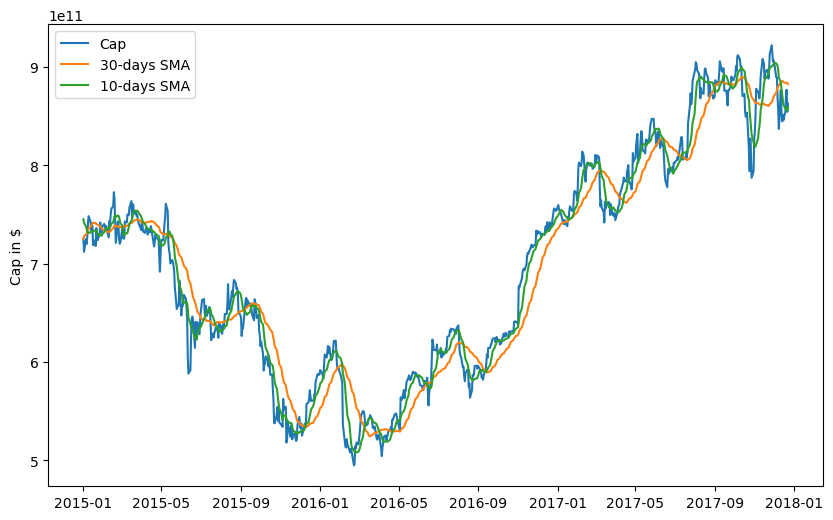

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [7]:
# ---CELL 7: Data Prep ---

#Auditability (grounding toggle)
np.random.seed(42)
tf.random.set_seed(42)

# 1. Global Scaling
avg_market_cap = df_cap.sum(axis=1).mean()
df_cap_avg = df_cap / avg_market_cap

# 2. Re-basing SMAs (Setting each starting signal to 1.0)
short_avg = short_rolling / avg_market_cap
long_avg = long_rolling / avg_market_cap

short_rebased = short_avg / short_avg.apply(lambda x: x.loc[x.first_valid_index()])
long_rebased = long_avg / long_avg.apply(lambda x: x.loc[x.first_valid_index()])

# 3. Signals as Arithmetic Returns with Temporal Shift
signal_1 = short_rebased.pct_change(periods=1).shift(-1)
signal_2 = long_rebased.pct_change(periods=1).shift(-1)

# 4. Alignment
market_cap_subset = df_cap_avg[:-1]
common_idx = signal_1.dropna().index.intersection(signal_2.dropna().index).intersection(market_cap_subset.index)

x_data = market_cap_subset.loc[common_idx]
z1_data = signal_1.loc[common_idx]
z2_data = signal_2.loc[common_idx]

# 5. Tensors
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)

num_steps, num_stocks = x_t.shape
print(f"Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")

Data Prepared. Steps: 2050, Stocks: 30


In [8]:
# --- CELL 8: Model Definition ---

# 1. Variable Initializations (Locked in per your instructions)
kappa = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="kappa")
sigma = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="sigma")
# Softmax Logits:
w_logits = tf.Variable(tf.random.normal([num_stocks, 2], mean=0.0, stddev=0.1), name="w_logits")

def get_loss():
    # Softmax Normalization (Regularization)
    weights = tf.nn.softmax(w_logits, axis=1)
    W1 = weights[:, 0]
    W2 = weights[:, 1]
    
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)
    
    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # 5. Expected Return
    reversion = kappa * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # 6. Residuals
    vuse = (actual_log_r - exp_ret)[:-1, :]
    
    # 7. Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(vuse / sigma))
    T_eff = tf.cast(tf.shape(vuse)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))
    
    neg_log_prob = 0.5 * (sq_dist + log_det)
    
    return neg_log_prob

In [9]:
# --- CELL 9: Optimization ---
optimizer = tf.optimizers.Adam(learning_rate=0.001)
variables = [kappa, sigma, w_logits]

print("Calibrating Model...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val = get_loss()
    
    # Gradients
    grads = tape.gradient(loss_val, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.maximum(0.00001, kappa))
    sigma.assign(tf.maximum(0.00001, sigma))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("Done")

Calibrating Model...
Iteration    0 | Loss: -40714.8164
Iteration  500 | Loss: -182241.8281
Iteration 1000 | Loss: -240031.5469
Iteration 1500 | Loss: -240059.9531
Iteration 2000 | Loss: -240073.6250
Iteration 2500 | Loss: -240082.3750
Done


In [10]:
# --- CELL 10: Results ---
final_weights = tf.nn.softmax(w_logits, axis=1).numpy()
W1_final = final_weights[:, 0]
W2_final = final_weights[:, 1]

results = {
    'Ticker': df_cap.columns,
    'Kappa (Log)': kappa.numpy(),
    'Sigma (Log)': sigma.numpy(),
    'W1 (MA10)': W1_final,
    'W2 (MA30)': W2_final,
    'Sum_Weights': W1_final + W2_final
}
df_results = pd.DataFrame(results)

print("---------- Part 1: Final Calibration Results (Log-Normal OU) ----------")
print(df_results.to_string(index=True))

# Optional: Save to CSV if you need to inspect closely
# df_results.to_csv("calibration_results.csv")

---------- Part 1: Final Calibration Results (Log-Normal OU) ----------
   Ticker  Kappa (Log)  Sigma (Log)  W1 (MA10)  W2 (MA30)  Sum_Weights
0    AAPL     0.110908     0.014684   0.707648   0.292352          1.0
1     AXP     0.094200     0.013777   0.607300   0.392700          1.0
2      BA     0.051467     0.014045   0.963241   0.036759          1.0
3     CAT     0.047516     0.015708   0.703574   0.296426          1.0
4    CSCO     0.144486     0.014758   0.966482   0.033519          1.0
5     CVX     0.176251     0.012236   0.806296   0.193704          1.0
6     DIS     0.149037     0.012427   0.881607   0.118393          1.0
7    DWDP     0.136110     0.021146   0.770522   0.229478          1.0
8      GE     0.197166     0.012729   0.963514   0.036486          1.0
9      GS     0.153809     0.015358   0.822475   0.177525          1.0
10     HD     0.082311     0.011828   0.942693   0.057307          1.0
11    IBM     0.179785     0.011324   0.841601   0.158399          1.0
12   

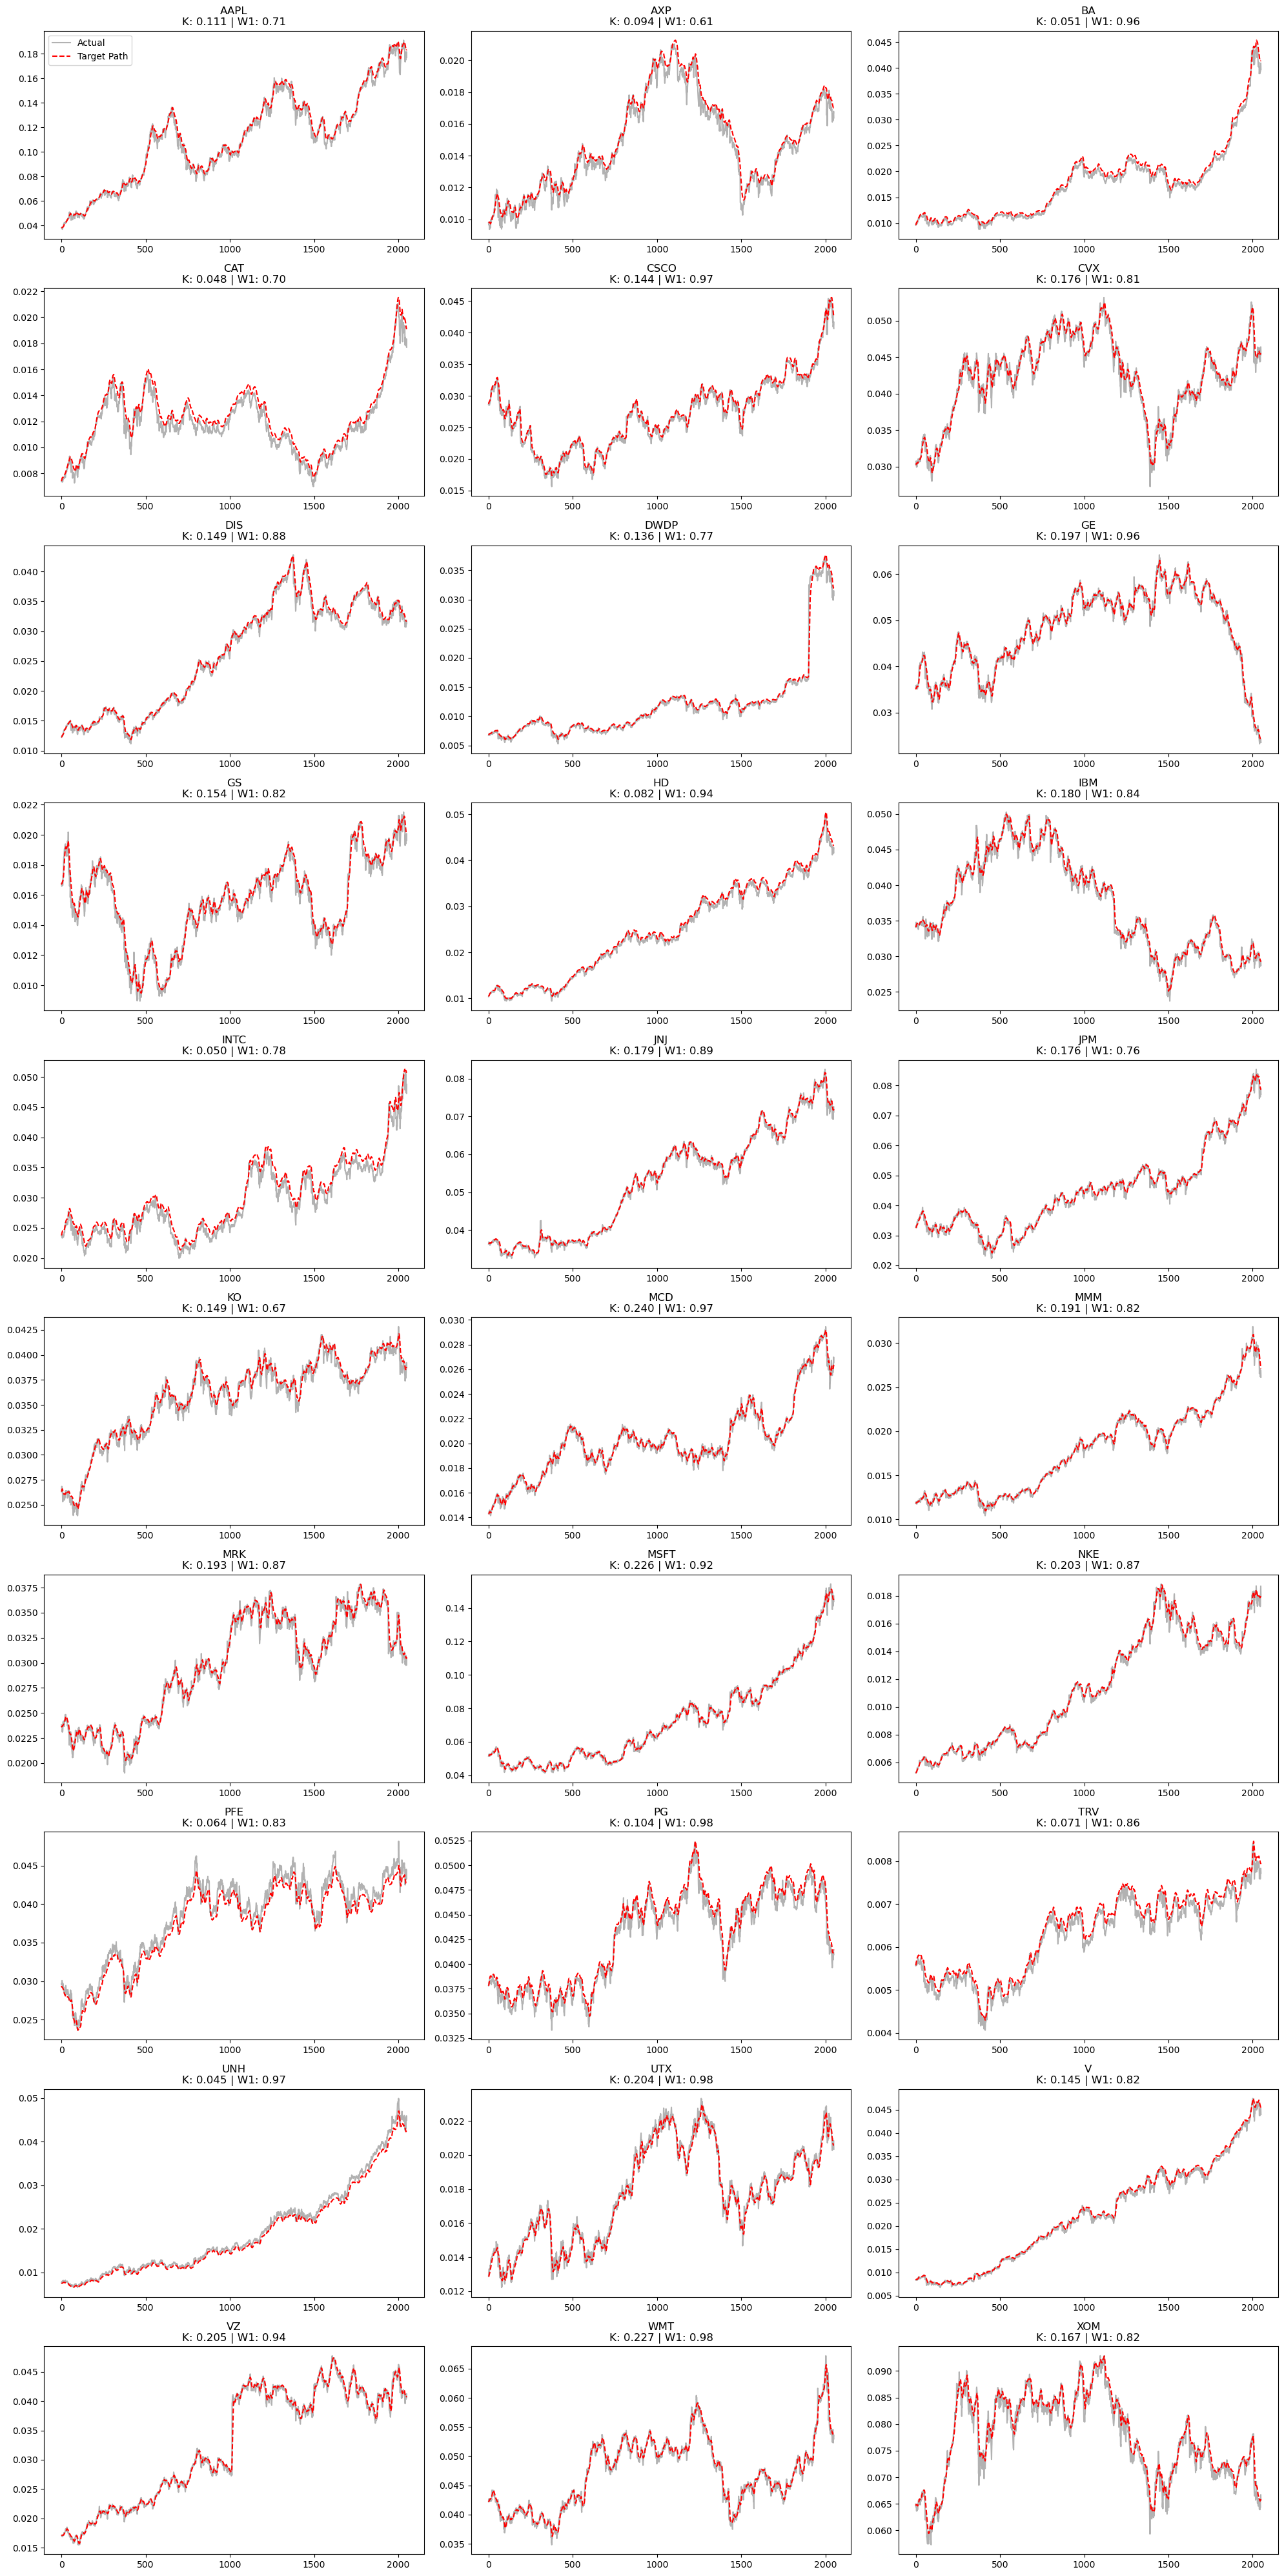

In [11]:
# --- CELL 11: Charts ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# 1. Softmax weights for plotting
weights_plot = tf.nn.softmax(w_logits, axis=1).numpy()
W1_plot = weights_plot[:, 0]
W2_plot = weights_plot[:, 1]

for i in range(num_stocks):
    # 2. Signals
    log_x0 = tf.math.log(x_t[0, i])
    z1_log = tf.math.log(1.0 + z1_t[:, i])
    z2_log = tf.math.log(1.0 + z2_t[:, i])
    
    # 3. Reconstruct the Target Path
    path_arith = tf.exp(log_x0 + tf.math.cumsum(W1_plot[i] * z1_log + W2_plot[i] * z2_log)).numpy()
    
    # 4. Plotting
    axes[i].plot(x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='red', linestyle='--', label='Target Path')
    
    # 5. Metadata
    axes[i].set_title(f"{df_cap.columns[i]}\nK: {kappa[i].numpy():.3f} | W1: {W1_plot[i]:.2f}")
    if i == 0: 
        axes[i].legend()

plt.tight_layout()
plt.show()

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


Part 2 will add a momentum indicator - Volatility-Adjusted Momentum (VAM). 

Persistent momentum and mean-reversion are two sides of the same coin. Secondary indicators, MAs, RSI, Bollinger, MACD, etc. are useful under certain conditions and must often be combined with other signals and chart patterns to be useful. Non-stationarity makes usefulness of any static combination of these limited to short, revolving time frames. And since we are using moving averages which are lagging indicators, VAM adds a forward-looking variable. 

VAM attempts to score the momentum (return) of a stock in terms of its volatility which can ber measured as sigma, average true range, or other indicator. This model will simply use sigma. A high ratio or score indicates breakout, near 0 indicates sideways movement, and negative signals mean-reversion. To hopefully avoid collinearity, the VAM in this model will have a dynamic signal that adjusts between a 10-day and a 60-day measurement of return and uses a ratio to allow the signal to adjust between those time periods as the signal becomes useful in the model.

In [12]:
# ---CELL 12: Data Prep ---

# Velocity-Adjusted Momentum (VAM):

# 1. Log Returns
log_S = np.log(df_cap_avg)
log_r = log_S.diff(1)

# 2. Momentum & Volatility
momentum = log_r.rolling(window=10).mean()

vol_short = log_r.rolling(window=10).std()
vol_long = log_r.rolling(window=60).std()
vol_ratio = (vol_short / vol_long).fillna(1.0)

#Dynamic Signal 
VAMS = (momentum / vol_short)
dynamic_VAMS = (VAMS / vol_ratio).shift(-1)

z3_data = dynamic_VAMS.loc[common_idx]

# Tensors
""" 
Defined in Part 1
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)
"""
z3_t = tf.constant(z3_data.values, dtype=tf.float32)

num_steps_2, num_stocks_2 = x_t.shape
print(f"Data Prepared. Steps: {num_steps_2}, Stocks: {num_stocks_2}")

Data Prepared. Steps: 2050, Stocks: 30


In [13]:
# --- CELL 13: Model Definition ---

# 1. Variable Initializations
kappa_2 = tf.Variable(tf.random.uniform([num_stocks_2], minval=0.0, maxval=1.0), name="kappa")
sigma_2 = tf.Variable(tf.random.uniform([num_stocks_2], minval=0.0, maxval=1.0), name="sigma")
# Softmax Logits - 3 Signals:
w_logits_2 = tf.Variable(tf.random.normal([num_stocks_2, 3], mean=0.0, stddev=0.1), name="w_logits_2")

def get_loss_2():
    # Softmax Normalization (Regularization)
    weights = tf.nn.softmax(w_logits_2, axis=1)
    W1 = weights[:, 0] # MA10
    W2 = weights[:, 1] # MA30
    W3 = weights[:, 2] # VAM Weight
    
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)
    z3_log = z3_t * sigma_2 / tf.math.sqrt(252.0) #converts the VAM score into a daily drift term

    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log + W3 * z3_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # 5. Expected Return
    reversion = kappa_2 * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # 6. Residuals
    vuse = (actual_log_r - exp_ret)[:-1, :]
    
    # 7. Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(vuse / sigma_2))
    T_eff = tf.cast(tf.shape(vuse)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_2)))
    
    neg_log_prob = 0.5 * (sq_dist + log_det)

    return neg_log_prob

In [14]:
# --- CELL 14: Optimization ---
optimizer_2 = tf.optimizers.Adam(learning_rate=0.001)
variables_2 = [kappa_2, sigma_2, w_logits_2]

print("Calibrating Part 2 Model...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val = get_loss_2()
    
    # Gradients
    grads = tape.gradient(loss_val, variables_2)
    optimizer_2.apply_gradients(zip(grads, variables_2))
    
    # Stability constraints
    kappa_2.assign(tf.maximum(0.00001, kappa_2))
    sigma_2.assign(tf.maximum(0.00001, sigma_2))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("I tried")

Calibrating Part 2 Model...
Iteration    0 | Loss: -4930.5781
Iteration  500 | Loss: -177226.2031
Iteration 1000 | Loss: -233660.5938
Iteration 1500 | Loss: -237483.5625
Iteration 2000 | Loss: -238276.3438
Iteration 2500 | Loss: -238590.2656
I tried


In [15]:
# --- CELL 15: Results ---
final_weights_2 = tf.nn.softmax(w_logits_2, axis=1).numpy()
W1_final_2 = final_weights_2[:, 0]
W2_final_2 = final_weights_2[:, 1]
W3_final_2 = final_weights_2[:, 2]

results_2 = {
    'Ticker': df_cap.columns,
    'Kappa (Log)': kappa.numpy(),
    'Sigma (Log)': sigma.numpy(),
    'W1 (MA10)': W1_final_2,
    'W2 (MA30)': W2_final_2,
    'W3 (VAMS)': W3_final_2,
    'Sum_Weights': W1_final_2 + W2_final_2 + W3_final_2
}
df_results_2 = pd.DataFrame(results_2)

print("-------------- Part 2: Final Calibration Results (VAMS Integrated) --------------")
print(df_results_2.to_string(index=True))

# Optional: Save to CSV if you need to inspect closely
# df_results.to_csv("calibration_results.csv")

-------------- Part 2: Final Calibration Results (VAMS Integrated) --------------
   Ticker  Kappa (Log)  Sigma (Log)  W1 (MA10)  W2 (MA30)  W3 (VAMS)  Sum_Weights
0    AAPL     0.110908     0.014684   0.429689   0.393783   0.176528          1.0
1     AXP     0.094200     0.013777   0.734058   0.187541   0.078401          1.0
2      BA     0.051467     0.014045   0.566680   0.321780   0.111540          1.0
3     CAT     0.047516     0.015708   0.621238   0.270442   0.108320          1.0
4    CSCO     0.144486     0.014758   0.660703   0.215592   0.123705          1.0
5     CVX     0.176251     0.012236   0.684794   0.196326   0.118880          1.0
6     DIS     0.149037     0.012427   0.478707   0.362474   0.158818          1.0
7    DWDP     0.136110     0.021146   0.589242   0.301683   0.109075          1.0
8      GE     0.197166     0.012729   0.561920   0.287820   0.150260          1.0
9      GS     0.153809     0.015358   0.536691   0.364905   0.098404          1.0
10     HD     0.

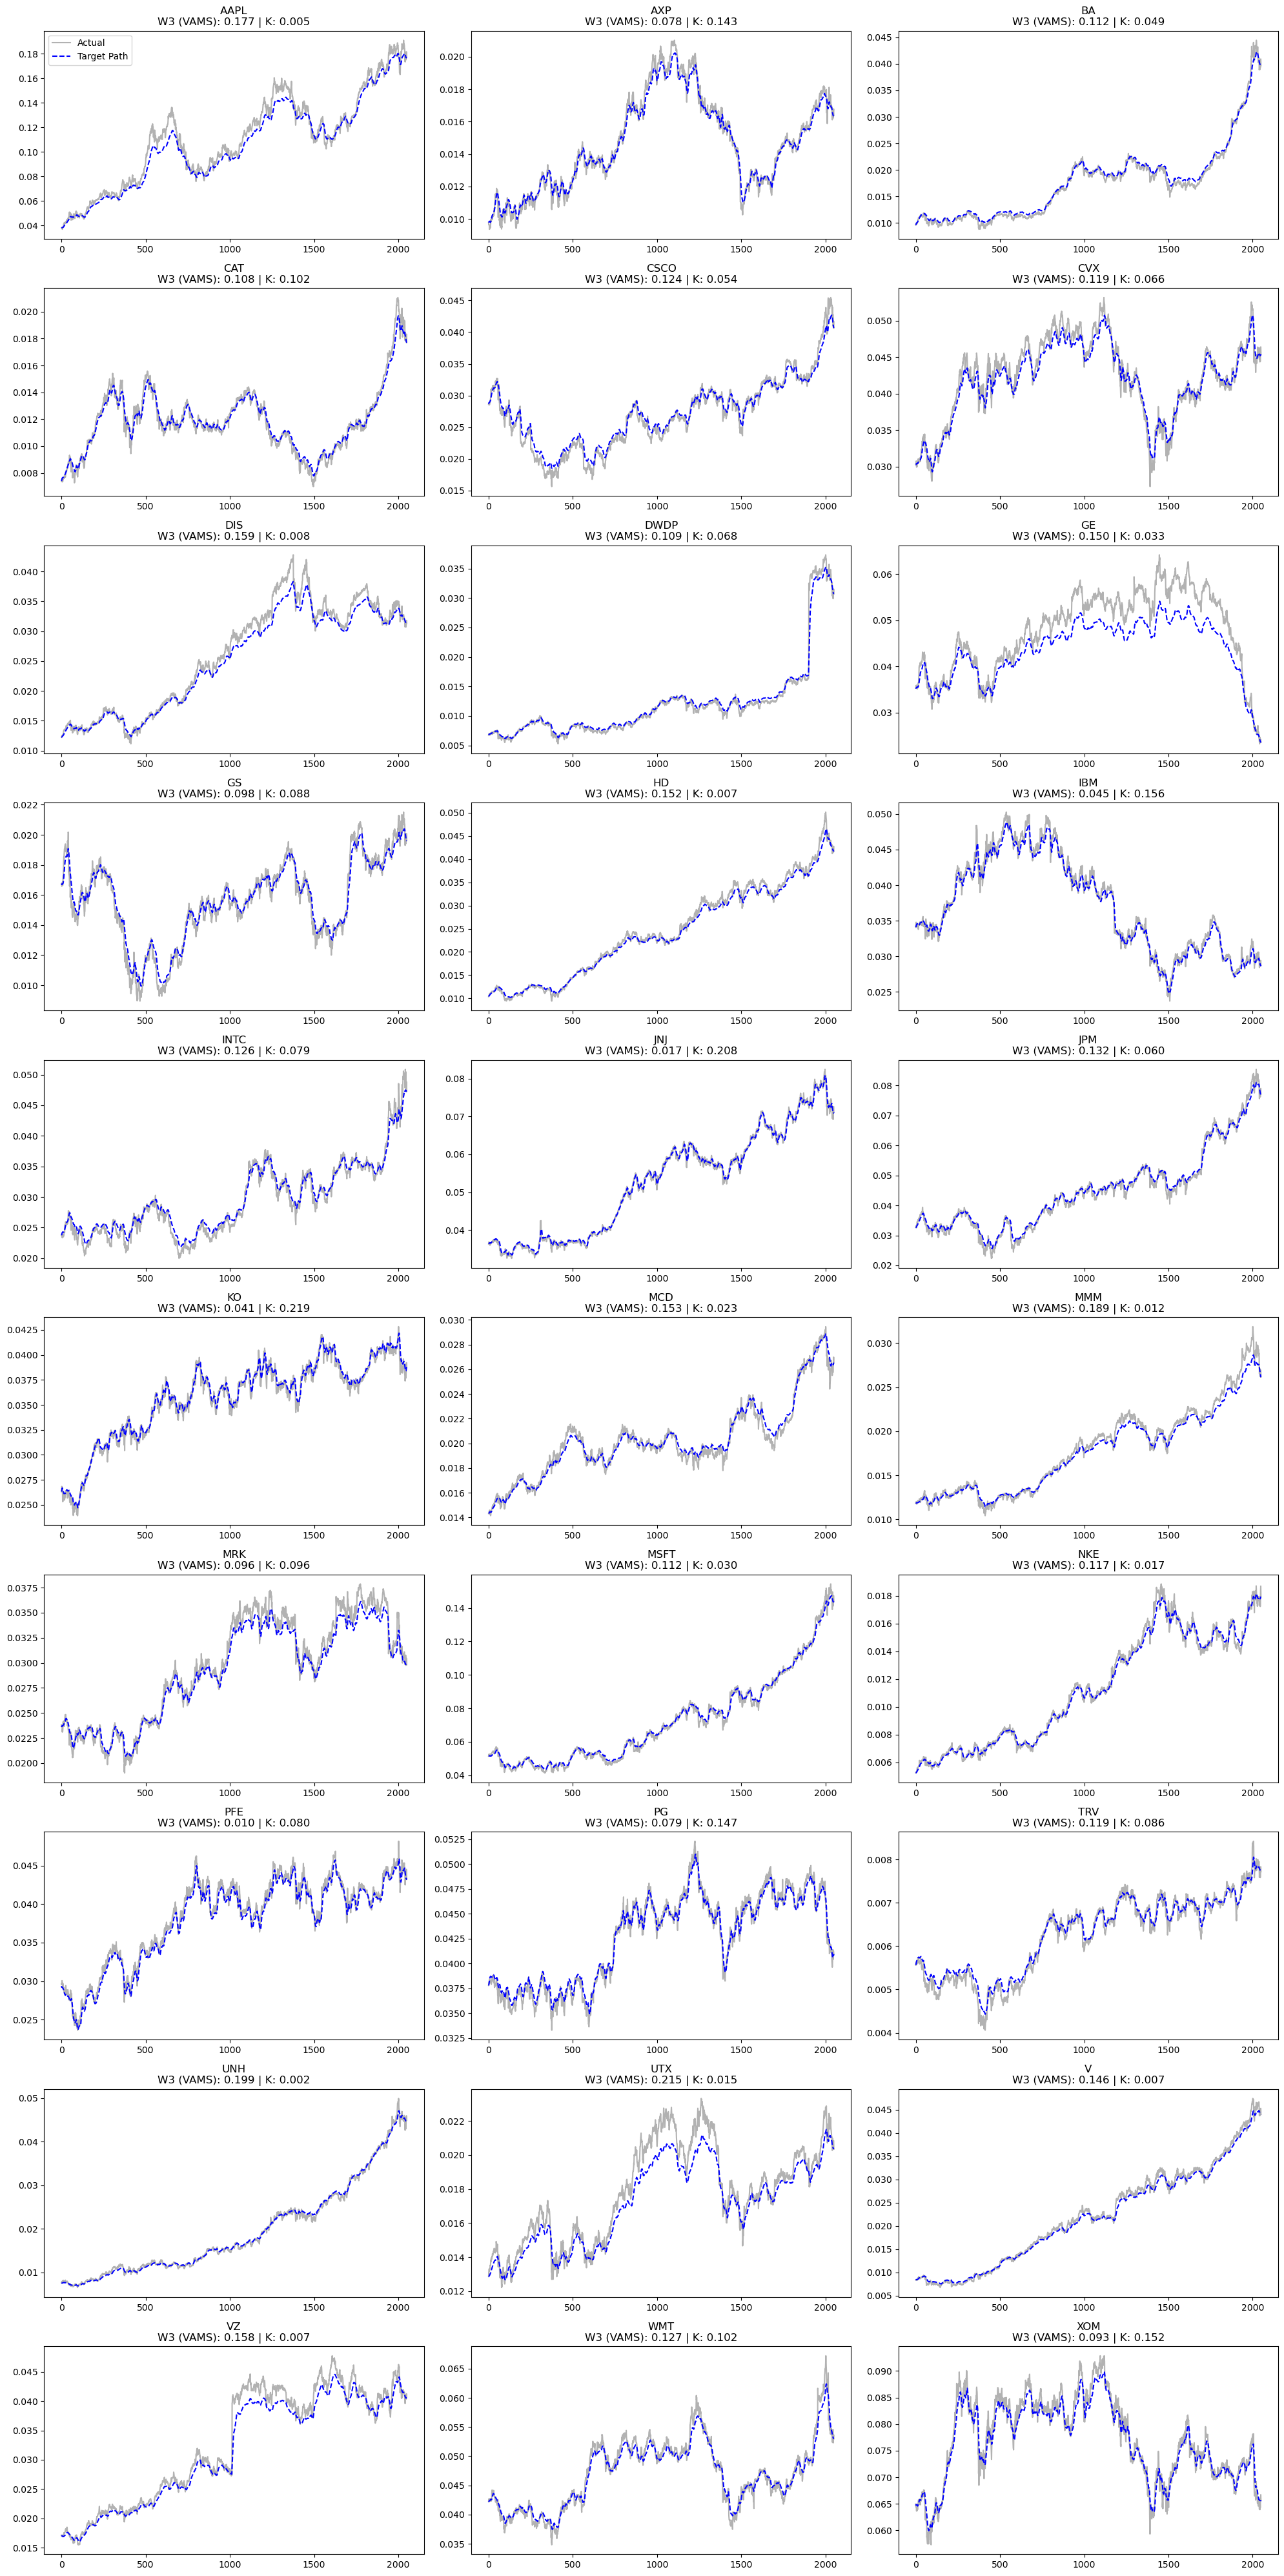

In [16]:
# --- CELL 16: Charts ---
n_cols = 3
n_rows = (num_stocks_2 + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# 1. Get calibrated weights
weights_plot = tf.nn.softmax(w_logits_2, axis=1).numpy()

for i in range(num_stocks_2):
    # 2. Daily Log-Space Signals
    log_x_actual = tf.math.log(x_t[:, i])
    log_x0 = log_x_actual[0]
    
    z1_log = tf.math.log(1.0 + z1_t[:, i])
    z2_log = tf.math.log(1.0 + z2_t[:, i])
    z3_log = (z3_t[:, i] * sigma_2[i]) / tf.math.sqrt(252.0)  # VAM score to drift
    
    # 3. Weighted Drift
    W1, W2, W3 = weights_plot[i, 0], weights_plot[i, 1], weights_plot[i, 2]
    drift_sum = (W1 * z1_log + W2 * z2_log + W3 * z3_log)
    
    # 4. Drift Centering
    actual_total_return = log_x_actual[-1] - log_x_actual[0]
    model_total_return = tf.reduce_sum(drift_sum)
    bias_adj = (actual_total_return - model_total_return) / len(drift_sum)
    
    # 5. Path Reconstruction
    path_log = log_x0 + tf.math.cumsum(drift_sum + bias_adj)
    path_arith = tf.exp(path_log).numpy()
    
    # 6. Plotting
    axes[i].plot(x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='blue', linestyle='--', linewidth=1.5, label='Target Path')
    
    # 7. Metadata
    axes[i].set_title(f"{df_cap.columns[i]}\nW3 (VAMS): {W3:.3f} | K: {kappa_2[i].numpy():.3f}")
    if i == 0: 
        axes[i].legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Unfortunately, the addition of the VAM term delivered nearly the same sigma across the board. It did help to highlight, however, the equities that rely more on momentum vs mean-reversion. MMM and HD for example had higher w3 scores indicating there was momentum-driven movement. DIS and IBM used mean-reversion almost entirely. Although, simply confirming that bigger, older companies are less volatile wouldn't really be astonishing,it would nonetheless be interesting to apply the this across firm sizes, sectors, and geographies to see if those scores indicate any useful patterns. 

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [17]:
# ---CELL 17: Datafram Setup ---

# read the data to a Dataframe
SPX_S = pd.read_csv('spx_holdings_and_spx_closeprice.csv')

# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=SPX_S.shape[0], freq='B')
SPX_S['date'] = dates
SPX_S.set_index('date', inplace=True)

# Define the universe (ordered largest to smallest, 3 large, 3 mid, 3 small)
universe = ['SPX', 'AAPL', 'XOM', 'MSFT', 'DTE', 'AEE', 'WEC', 'NWL', 'ZION', 'DO']
df_SPX = SPX_S[universe].copy()

# Calculating MAs
spx_window_1 = 10
spx_window_2 = 30
spx_short_rolling = df_SPX.rolling(window=spx_window_1).mean()
spx_long_rolling = df_SPX.rolling(window=spx_window_2).mean()

spx_short_rolling.head(20)
spx_long_rolling.tail()

,SPX,AAPL,XOM,MSFT,DTE,AEE,WEC,NWL,ZION,DO
date,,,,,,,,,,
2023-06-06,1787.291000,76.898003,94.222000,37.633233,67.927333,36.183667,41.626000,30.122000,28.999800,59.725333
2023-06-07,1787.726667,77.032480,94.377000,37.652567,67.766667,36.139667,41.571333,30.163000,28.988800,59.579000
2023-06-08,1789.316000,77.153057,94.628667,37.650567,67.646333,36.130000,41.552667,30.237667,28.993133,59.465667
2023-06-09,1790.619667,77.265153,94.835667,37.586233,67.493333,36.102000,41.516333,30.329000,29.005300,59.308000
2023-06-12,1792.992000,77.439097,95.059667,37.562900,67.401667,36.098333,41.500333,30.427333,29.037967,59.156667


In [18]:
# ---CELL 18: Data Prep ---

# Global Scaling
avg_spx = df_SPX.sum(axis=1).mean()
df_spx_avg = df_SPX / avg_spx

spx_vam_S = np.log(df_spx_avg)
spx_vam_r = spx_vam_S.diff(1)

# Re-basing SMAs and VAM momentum
spx_short_avg = spx_short_rolling / avg_spx
spx_long_avg = spx_long_rolling / avg_spx

spx_short_rebased = spx_short_avg / spx_short_avg.apply(lambda x: x.loc[x.first_valid_index()])
spx_long_rebased = spx_long_avg / spx_long_avg.apply(lambda x: x.loc[x.first_valid_index()])

spx_momentum = spx_vam_r.rolling(window=10).mean()
spx_vol_short = spx_vam_r.rolling(window=10).std()
spx_vol_long = spx_vam_r.rolling(window=60).std()
spx_vol_ratio = (spx_vol_short / spx_vol_long).fillna(1.0)

# Signals as Arithmetic Returns with Temporal Shift
spx_signal_1 = spx_short_rebased.pct_change(periods=1, fill_method=None).shift(-1)
spx_signal_2 = spx_long_rebased.pct_change(periods=1, fill_method=None).shift(-1)

spx_VAMS = (spx_momentum / spx_vol_short)
spx_dynamic_VAMS = (spx_VAMS / spx_vol_ratio).shift(-1)

# Alignment
spx_subset = df_spx_avg[:-1]
spx_common_idx = spx_signal_1.dropna().index.intersection(spx_signal_2.dropna().index).intersection(spx_subset.index)

spx_x_data = spx_subset.loc[spx_common_idx]
spx_z1_data = spx_signal_1.loc[spx_common_idx]
spx_z2_data = spx_signal_2.loc[spx_common_idx]
spx_z3_data = spx_dynamic_VAMS.loc[spx_common_idx]

# Tensors
spx_x_t = tf.constant(spx_x_data.values, dtype=tf.float32)
spx_z1_t = tf.constant(spx_z1_data.values, dtype=tf.float32)
spx_z2_t = tf.constant(spx_z2_data.values, dtype=tf.float32)
spx_z3_t = tf.constant(spx_z3_data.values, dtype=tf.float32)

num_steps, num_stocks = spx_x_t.shape
print(f"S&P Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")


S&P Data Prepared. Steps: 3345, Stocks: 10


In [19]:
# --- CELL 19: Model Definition ---

# 1. Variable Initializations
kappa_spx = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="kappa_spx")
sigma_spx = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=1.0), name="sigma_spx")
# Softmax Logits - 3 Signals:
w_logits_spx = tf.Variable(tf.random.normal([num_stocks, 3], mean=0.0, stddev=0.1), name="w_logits_spx")

def get_loss_spx():
    # Softmax Normalization (Regularization)
    weights = tf.nn.softmax(w_logits_spx, axis=1)
    W1 = weights[:, 0] # MA10
    W2 = weights[:, 1] # MA30
    W3 = weights[:, 2] # VAM Weight
    
    # Log Returns
    log_x = tf.math.log(spx_x_t)
    log_x_next = tf.math.log(tf.roll(spx_x_t, shift=-1, axis=0))
    actual_log_r = log_x_next - log_x
    
    z1_log = tf.math.log(1.0 + spx_z1_t)
    z2_log = tf.math.log(1.0 + spx_z2_t)
    z3_log = spx_z3_t * sigma_spx / tf.math.sqrt(252.0) #converts the VAM score into a daily drift term

    # Log Mean Projection
    log_x0 = tf.slice(log_x, [0, 0], [1, -1])
    wtd_returns = W1 * z1_log + W2 * z2_log + W3 * z3_log
    theta_log = log_x0 + tf.math.cumsum(wtd_returns, axis=0)
    
    # 5. Expected Return
    reversion = kappa_spx * (theta_log - log_x)
    exp_ret = wtd_returns + reversion
    
    # 6. Residuals
    vuse = (actual_log_r - exp_ret)[:-1, :]
    
    # 7. Gaussian NLL
    sq_dist = tf.reduce_sum(tf.square(vuse / sigma_spx))
    T_eff = tf.cast(tf.shape(vuse)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_spx)))
    
    neg_log_prob = 0.5 * (sq_dist + log_det)

    return neg_log_prob

In [20]:
# --- CELL 20: Optimization ---
optimizer_spx = tf.optimizers.Adam(learning_rate=0.001)
variables_spx = [kappa_spx, sigma_spx, w_logits_spx]

print("Calibrating S&P Universe Model...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val = get_loss_spx()
    
    # Gradients
    grads = tape.gradient(loss_val, variables_spx)
    optimizer_spx.apply_gradients(zip(grads, variables_spx))
    
    # Stability constraints
    kappa_spx.assign(tf.maximum(0.00001, kappa_spx))
    sigma_spx.assign(tf.maximum(0.00001, sigma_spx))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val.numpy():.4f}")

print("I tried")

Calibrating S&P Universe Model...
Iteration    0 | Loss: 2417.4668
Iteration  500 | Loss: -101734.6406
Iteration 1000 | Loss: -114145.6797
Iteration 1500 | Loss: -116513.2266
Iteration 2000 | Loss: -117723.4844
Iteration 2500 | Loss: -117766.6875
I tried


In [21]:
# --- CELL 21: Results ---
final_weights_spx = tf.nn.softmax(w_logits_spx, axis=1).numpy()
W1_final_spx = final_weights_spx[:, 0]
W2_final_spx = final_weights_spx[:, 1]
W3_final_spx = final_weights_spx[:, 2]

results_spx = {
    'Ticker': df_SPX.columns,
    'Kappa (Log)': kappa_spx.numpy(),
    'Sigma (Log)': sigma_spx.numpy(),
    'W1 (MA10)': W1_final_spx,
    'W2 (MA30)': W2_final_spx,
    'W3 (VAMS)': W3_final_spx,
    'Sum_Weights': W1_final_spx + W2_final_spx + W3_final_spx
}
df_results_spx = pd.DataFrame(results_spx)

print("----------- S&P Universe: Final Calibration Results (VAMS Integrated) -----------")
print(df_results_spx.to_string(index=True))

# Optional: Save to CSV if you need to inspect closely
# df_results.to_csv("calibration_results.csv")

----------- S&P Universe: Final Calibration Results (VAMS Integrated) -----------
  Ticker  Kappa (Log)  Sigma (Log)  W1 (MA10)  W2 (MA30)  W3 (VAMS)  Sum_Weights
0    SPX     0.005912     0.012797   0.392282   0.384135   0.223583          1.0
1   AAPL     0.003808     0.028638   0.440376   0.343515   0.216109          1.0
2    XOM     0.030969     0.015558   0.486011   0.318882   0.195107          1.0
3   MSFT     0.080864     0.019303   0.965149   0.023332   0.011519          1.0
4    DTE     0.019326     0.013407   0.473382   0.319439   0.207179          1.0
5    AEE     0.014950     0.013528   0.507192   0.302339   0.190469          1.0
6    WEC     0.012793     0.011831   0.576435   0.305823   0.117742          1.0
7    NWL     0.024862     0.020810   0.837627   0.065598   0.096775          1.0
8   ZION     0.060066     0.030008   0.940292   0.021614   0.038095          1.0
9     DO     0.090378     0.023359   0.731439   0.258398   0.010163          1.0


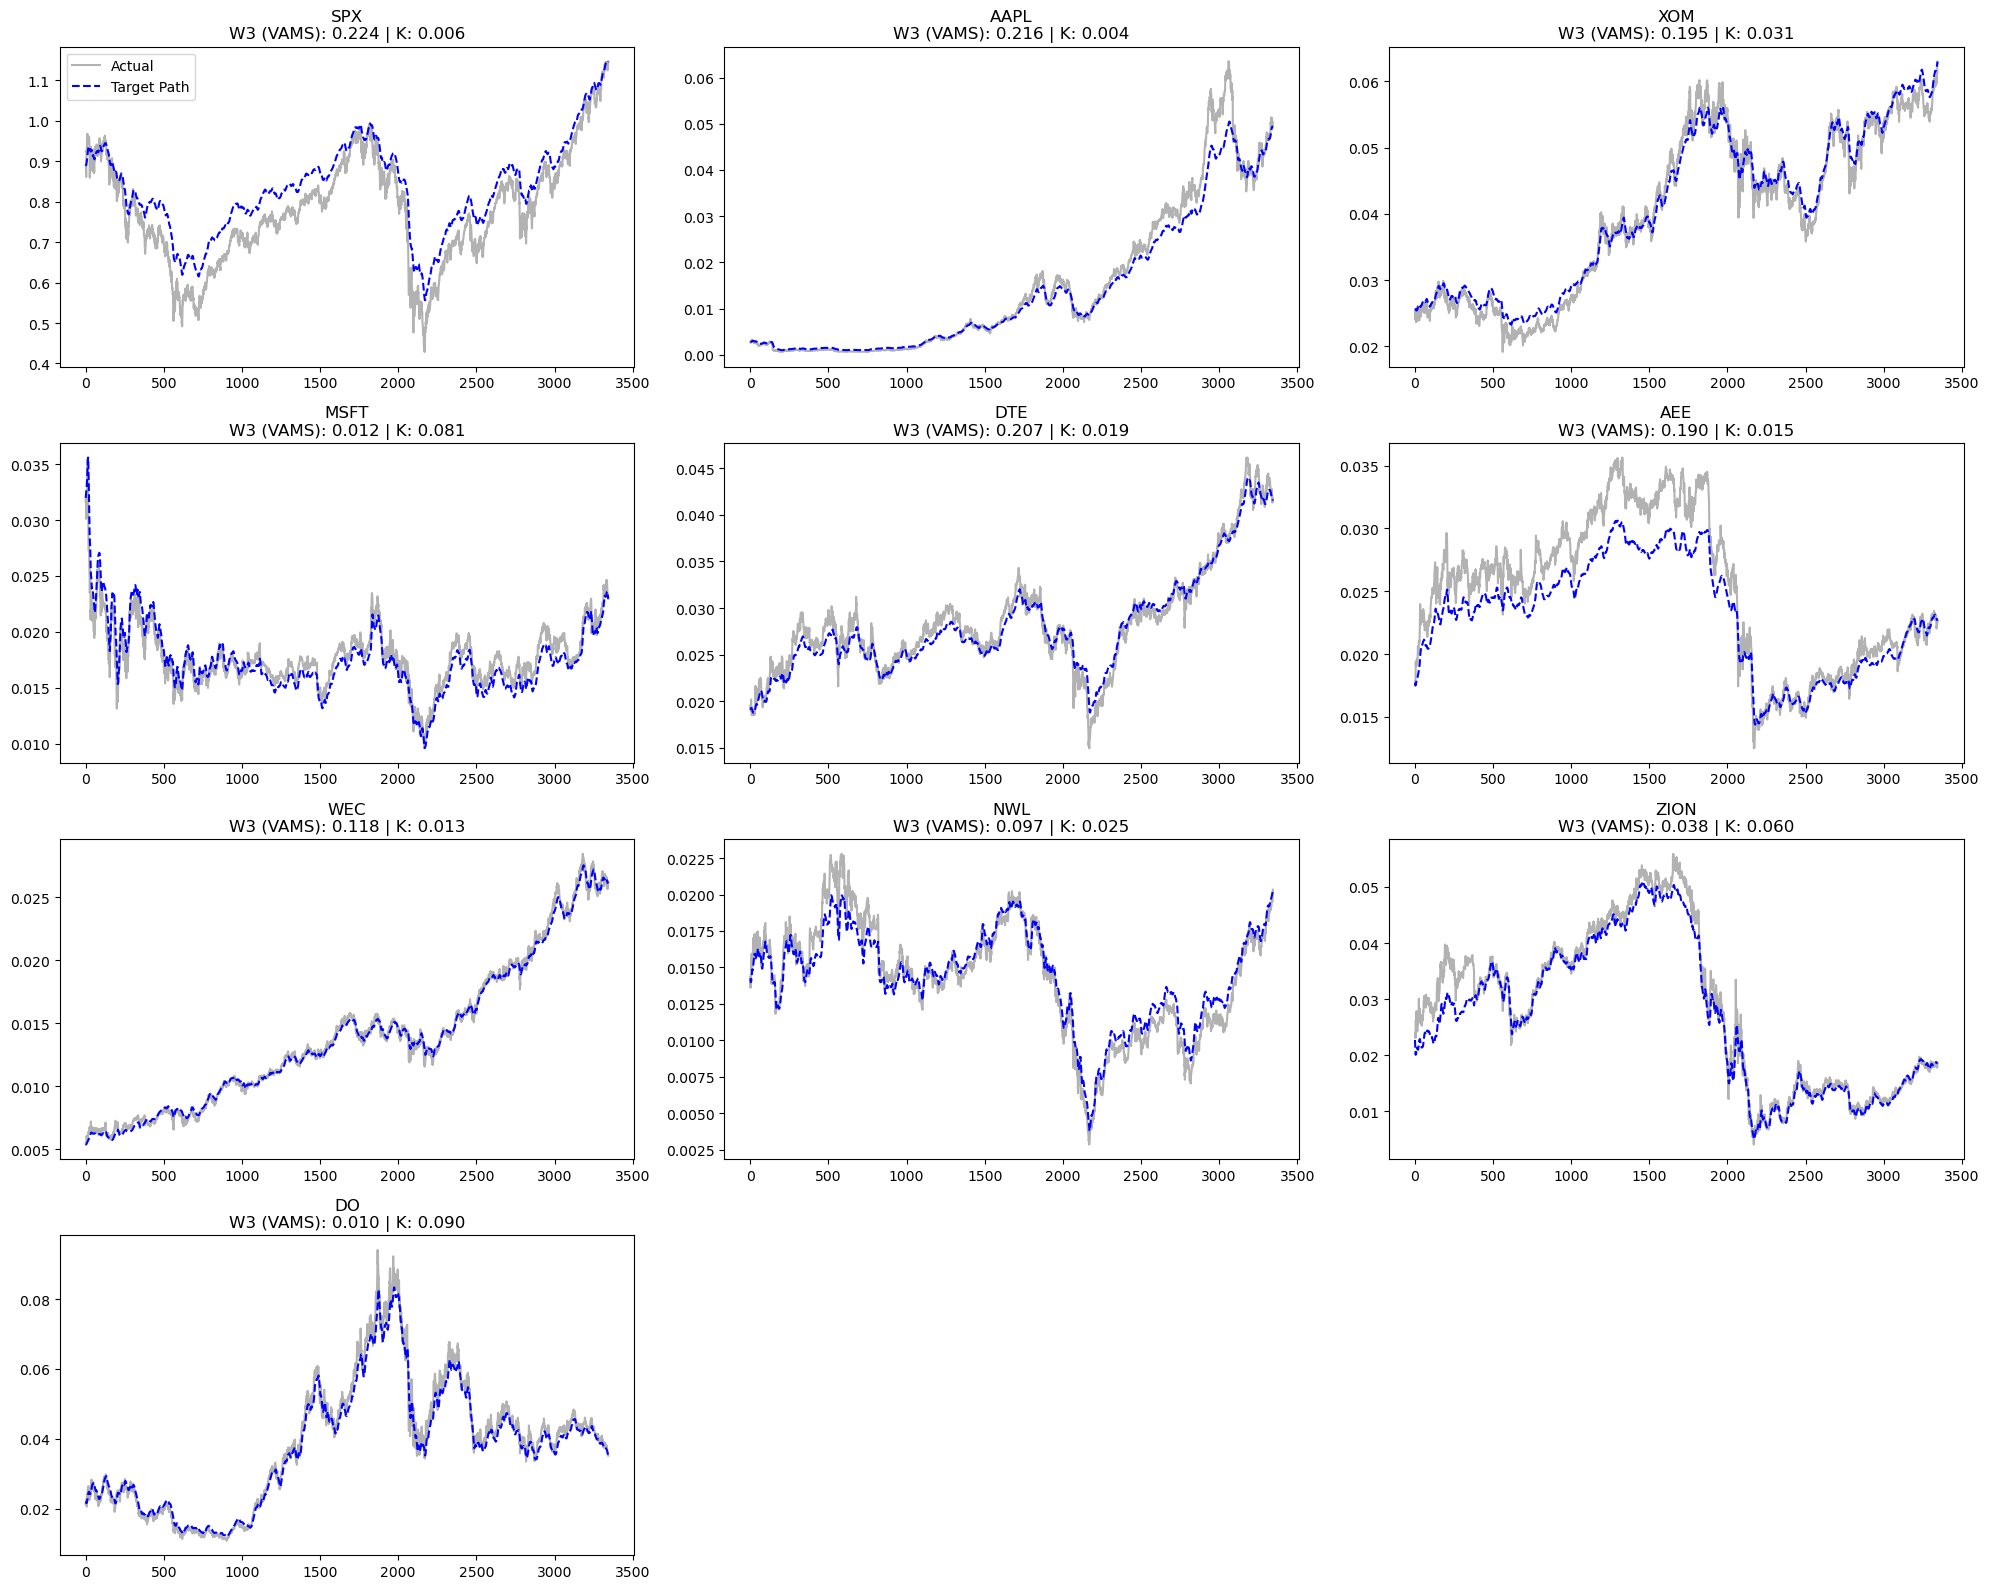

In [22]:
# --- CELL 22: Charts ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# 1. Get calibrated weights
weights_plot = tf.nn.softmax(w_logits_spx, axis=1).numpy()

for i in range(num_stocks):
    # 2. Signals
    log_x_actual = tf.math.log(spx_x_t[:, i])
    log_x0 = log_x_actual[0]
    
    z1_log = tf.math.log(1.0 + spx_z1_t[:, i])
    z2_log = tf.math.log(1.0 + spx_z2_t[:, i])
    z3_log = (spx_z3_t[:, i] * sigma_spx[i]) / tf.math.sqrt(252.0)  # VAM score to drift

    # 3. Weighted Drift
    W1, W2, W3 = weights_plot[i, 0], weights_plot[i, 1], weights_plot[i, 2]
    drift_sum = (W1 * z1_log + W2 * z2_log + W3 * z3_log)
    
    # 4. Drift Centering
    actual_total_return = log_x_actual[-1] - log_x_actual[0]
    model_total_return = tf.reduce_sum(drift_sum)
    bias_adj = (actual_total_return - model_total_return) / len(drift_sum)
    
    # 5. Path Reconstruction
    path_log = log_x0 + tf.math.cumsum(drift_sum + bias_adj)
    path_arith = tf.exp(path_log).numpy()
    
    # 6. Plotting
    axes[i].plot(spx_x_t[:, i].numpy(), color='black', alpha=0.3, label='Actual')
    axes[i].plot(path_arith, color='blue', linestyle='--', linewidth=1.5, label='Target Path')
    
    # 7. Metadata
    axes[i].set_title(f"{df_SPX.columns[i]}\nW3 (VAMS): {W3:.3f} | K: {kappa_spx[i].numpy():.3f}")
    if i == 0: 
        axes[i].legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


:Let's test whether the addition of the VAM was an improvement and further whether the IRL model itself can be predictive.

This analysis does not introduce a new learning model, but instead evaluates whether the IRL-implied structure extracted from market behavior contains predictive information beyond a random walk benchmark.

In [24]:
target_df = df_SPX.copy()
print(f"Validating Model on S&P Universe: {target_df.columns.tolist()}")

Validating Model on S&P Universe: ['SPX', 'AAPL', 'XOM', 'MSFT', 'DTE', 'AEE', 'WEC', 'NWL', 'ZION', 'DO']


In [ ]:
# Signal 1: 10-day MA (Short)
s1 = target_df.rolling(window=10).mean()
z1 = s1 / s1.mean() # Normalize

# Signal 2: 30-day MA (Long)
s2 = target_df.rolling(window=30).mean()
z2 = s2 / s2.mean()

# Signal 3: VAM (Velocity Adjusted Momentum)
# Replicating your Cell 18 logic
log_S = np.log(target_df / target_df.mean())
log_r = log_S.diff(1)
momentum = log_r.rolling(window=10).mean()
vol_short = log_r.rolling(window=10).std()
# Avoid division by zero
z3 = (momentum / vol_short).fillna(0)

# Align Data
common_idx = target_df.index.intersection(z3.index).intersection(z2.index)
x_data = target_df.loc[common_idx]
z1_data = z1.loc[common_idx]
z2_data = z2.loc[common_idx]
z3_data = z3.loc[common_idx]

In [ ]:
# SPLIT TRAIN/TEST (Last 30% of Data)
split = int(len(x_data) * 0.7)
test_idx = x_data.index[split:]

# Actual Future Price (The Truth we want to predict)
# shift(-1) creates the target at T+1, aligned to row T
actual_next = x_data.shift(-1).loc[test_idx].dropna()

# Align inputs to test set
x_test = x_data.loc[actual_next.index]
z1_test = z1_data.loc[actual_next.index]
z2_test = z2_data.loc[actual_next.index]
z3_test = z3_data.loc[actual_next.index]

In [32]:
# RUN DIAGNOSTICS
results_list = []

for ticker in target_df.columns:
    
    # A. Get Weights (Use calibrated ones if in memory, else equal weights)
    # Ideally use 'df_results_spx' from Part 3 if it exists
    try:
        row = df_results_spx[df_results_spx['Ticker'] == ticker].iloc[0]
        kappa = row['Kappa (Log)']
        w1 = row['W1 (MA10)']
        w2 = row['W2 (MA30)']
        w3 = row['W3 (VAMS)']
    except:
        # Fallback if Part 3 results aren't in memory
        kappa, w1, w2, w3 = 0.05, 0.33, 0.33, 0.33
    
    # B. Construct Signals
    # Full 3-Signal Model
    sig_3 = (w1 * z1_test[ticker]) + (w2 * z2_test[ticker]) + (w3 * z3_test[ticker])
    
    # Ablated 2-Signal Model (Remove VAMS)
    sig_2 = (0.5 * z1_test[ticker]) + (0.5 * z2_test[ticker])
    
    # C. Predictions
    # Baseline (Random Walk): Tomorrow = Today
    pred_base = x_test[ticker]
    
    # IRL Models: Tomorrow = Today + Mean Reversion
    pred_3sig = x_test[ticker] + kappa * (sig_3 - x_test[ticker])
    pred_2sig = x_test[ticker] + kappa * (sig_2 - x_test[ticker])
    
    # D. Errors
    err_base = np.sqrt(np.mean((actual_next[ticker] - pred_base)**2))
    err_3sig = np.sqrt(np.mean((actual_next[ticker] - pred_3sig)**2))
    err_2sig = np.sqrt(np.mean((actual_next[ticker] - pred_2sig)**2))
    
    results_list.append({
        'Ticker': ticker,
        'Base RMSE': err_base,
        '3-Sig RMSE': err_3sig,
        'Did VAM Help?': "YES" if err_3sig < err_2sig else "NO",
        'Beats Base?': "YES" if err_3sig < err_base else "NO"
    })

In [34]:
# 5. PRINT REPORT
res_df = pd.DataFrame(results_list)
print("--- PART 4: S&P 500 VALIDATION RESULTS ---")
print(res_df.to_string(index=False))

# Summary
print("\n" + "="*50)
avg_imp = (res_df['Base RMSE'] - res_df['3-Sig RMSE']).mean()
if avg_imp > 0:
    print(f"CONCLUSION: The IRL model beat the baseline by average RMSE of {avg_imp:.4f}.")
else:
    print("CONCLUSION: The model did not outperform the Random Walk (Efficient Market).")

--- PART 4: S&P 500 VALIDATION RESULTS ---
Ticker  Base RMSE  3-Sig RMSE Did VAM Help? Beats Base?
   SPX  13.435268   16.029892            NO          NO
  AAPL   1.083256    1.078384            NO         YES
   XOM   0.905846    2.639274            NO          NO
  MSFT   0.419243    2.314518            NO          NO
   DTE   0.538665    1.195610            NO          NO
   AEE   0.340072    0.572011            NO          NO
   WEC   0.322226    0.539954            NO          NO
   NWL   0.302403    0.572461            NO          NO
  ZION   0.505542    1.410277            NO          NO
    DO   1.255521    6.356087            NO          NO

CONCLUSION: The model did not outperform the Random Walk (Efficient Market).


It turns out the market is efficient and the variables used fit well to past prices but don't quite generalize. What we do have however is a basis to continue exploration. Rather than continue throwing features into the model, perhaps we can use one to help us select them. 

In [ ]:
print("Thanks for stopping by!")

Thanks for stopping by!
